In [1]:
cd ..

C:\Users\jeros\PycharmProjects\ASDF-Dashboard


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sb
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.cluster import *
from sklearn.metrics import accuracy_score
import shap
import lime
import subgroup_detection.fairness as sdf
import subgroup_detection.clustering as sdc
import subgroup_detection.metrics as sdm
import subgroup_detection.util as sdu

# COMPAS
## Load dataset

In [4]:
compas_path = 'data/compas.csv'
with open(compas_path, 'r') as f:
    compas = pd.read_csv(compas_path)
label_cols = ['out', 'class']
compas

,age,c_charge_degree,race,sex,priors_count,days_b_screening_arrest,jail_length_days,out,class
0,69,Felony,Other,Male,0,-1.0,0,0,0
1,34,Felony,African-American,Male,0,-1.0,10,0,1
2,24,Felony,African-American,Male,4,-1.0,1,0,1
3,44,Misdemeanor,Other,Male,0,0.0,1,0,0
4,41,Felony,Caucasian,Male,14,-1.0,6,1,1
...,...,...,...,...,...,...,...,...,...
6167,23,Felony,African-American,Male,0,-1.0,1,1,0
6168,23,Felony,African-American,Male,0,-1.0,1,0,0
6169,57,Felony,Other,Male,0,-1.0,1,0,0
6170,33,Misdemeanor,African-American,Female,3,-1.0,1,0,0


In [5]:
compas.drop(columns=label_cols).describe()

,age,priors_count,days_b_screening_arrest,jail_length_days
count,6172.000000,6172.000000,6172.000000,6172.000000
mean,34.534511,3.246436,-1.740279,14.622813
std,11.730938,4.743770,5.084709,46.693528
min,18.000000,0.000000,-30.000000,-1.000000
25%,25.000000,0.000000,-1.000000,0.000000
50%,31.000000,1.000000,-1.000000,1.000000
75%,42.000000,4.000000,-1.000000,5.000000
max,96.000000,38.000000,30.000000,799.000000


In [6]:
compasX = sdu.prepare(compas)
compasX

,age,priors_count,days_b_screening_arrest,jail_length_days,c_charge_degree#Misdemeanor,race#Asian,race#Caucasian,race#Hispanic,race#Native American,race#Other,sex#Male
0,0.653846,0.000000,0.483333,0.00125,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.205128,0.000000,0.483333,0.01375,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.076923,0.105263,0.483333,0.00250,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.333333,0.000000,0.500000,0.00250,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.294872,0.368421,0.483333,0.00875,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
6167,0.064103,0.000000,0.483333,0.00250,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6168,0.064103,0.000000,0.483333,0.00250,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6169,0.500000,0.000000,0.483333,0.00250,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6170,0.192308,0.078947,0.483333,0.00250,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
compasY = compas['class']
trainX, testX, trainY, testY = train_test_split(compasX, compasY, test_size=0.1, shuffle=True, random_state=42, stratify=compasY)

np.shape(trainX), np.shape(trainY), np.shape(testX), np.shape(testY)

((5554, 11), (5554,), (618, 11), (618,))

In [8]:
shap.initjs()
kmeans = KMeans(n_clusters=10).fit(compasX.values)
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1858,  806,  427,  995,  626,  258,  401,  249,  233,  319],
       dtype=int64))

In [9]:
compasX.iloc[0:100]

,age,priors_count,days_b_screening_arrest,jail_length_days,c_charge_degree#Misdemeanor,race#Asian,race#Caucasian,race#Hispanic,race#Native American,race#Other,sex#Male
0,0.653846,0.000000,0.483333,0.00125,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.205128,0.000000,0.483333,0.01375,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.076923,0.105263,0.483333,0.00250,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.333333,0.000000,0.500000,0.00250,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.294872,0.368421,0.483333,0.00875,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
95,0.205128,0.000000,0.500000,0.01875,0.0,0.0,1.0,0.0,0.0,0.0,1.0
96,0.192308,0.131579,0.500000,0.00125,0.0,0.0,0.0,0.0,0.0,0.0,1.0
97,0.243590,0.078947,0.500000,0.00250,0.0,0.0,0.0,0.0,0.0,0.0,1.0
98,0.307692,0.026316,0.500000,0.00125,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [10]:
kmeans.predict(compasX.iloc[0:10]), kmeans.score(compasX)

X has feature names, but KMeans was fitted without feature names
X has feature names, but KMeans was fitted without feature names


(array([9, 0, 0, 9, 3, 9, 8, 3, 1, 8]), -625.2422282938835)

In [11]:
acc = 0
for i in range(0,len(compasX)):
    acc += kmeans.score(compasX.iloc[i].values.reshape(1,-1))
acc

-625.2422282938834

In [12]:
import warnings
warnings.filterwarnings("ignore")

explainer = shap.KernelExplainer(kmeans.predict, pd.DataFrame(kmeans.cluster_centers_, columns=compasX.columns))
print('Expected value:', explainer.expected_value)

shap_values = explainer.shap_values(compasX.iloc[0:100])
shap_values

Expected value: 4.500000000000001


  0%|          | 0/100 [00:00<?, ?it/s]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         4.95      , -1.01666667],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.9       , -2.06666667],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.9       , -2.06666667],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.9       , -2.06666667],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.55      , -1.73333333],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.9       , -2.06666667]])

In [13]:
shap.force_plot(explainer.expected_value, shap_values[0], feature_names=compasX.columns)

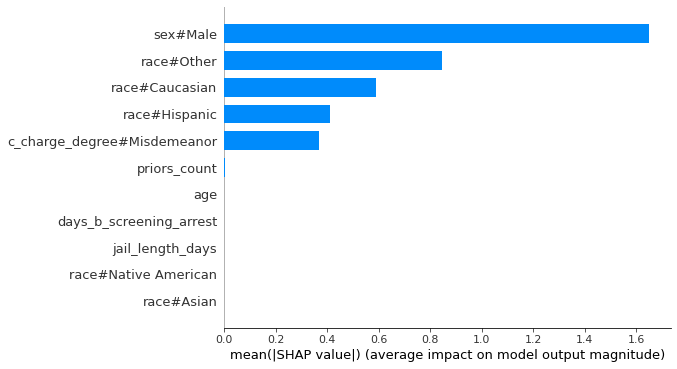

In [14]:
shap.summary_plot(shap_values, compasX.iloc[0:100], plot_type='bar')

## k-Means

In [13]:
compasX = compas.drop(columns=label_cols)
compasX = pd.get_dummies(compasX, drop_first=True, prefix_sep='#')
compasX = pd.DataFrame(MinMaxScaler().fit_transform(compasX), columns=compasX.columns)
kmeans = KMeans(n_clusters=20).fit(compasX)
labels = kmeans.predict(compasX)

In [14]:
cluster_shap = sdc.explain_clustering_shap(kmeans, compasX, )

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

In [17]:
cluster_rules = sdc.patterns_from_cluster_shap(cluster_shap, compas, compasX, labels)
cluster_rules

{0: [('age', '<=', 37),
  ('c_charge_degree', '=', 'Felony'),
  ('race', '!=', 'Caucasian'),
  ('race', '!=', 'Hispanic'),
  ('race', '!=', 'Other'),
  ('sex', '=', 'Male')],
 1: [('age', '>=', 36),
  ('age', '<=', 74),
  ('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Male')],
 2: [('age', '>=', 19),
  ('age', '<=', 43),
  ('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '!=', 'Caucasian'),
  ('race', '!=', 'Hispanic'),
  ('race', '!=', 'Other'),
  ('sex', '=', 'Male')],
 3: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Male')],
 4: [('c_charge_degree', '=', 'Felony'),
  ('race', '!=', 'Caucasian'),
  ('race', '!=', 'Hispanic'),
  ('race', '!=', 'Other'),
  ('sex', '=', 'Female')],
 5: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Female')],
 6: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Female')],
 7: [('c_charge_degree', '='

In [19]:
sdm.print_pattern_metrics(cluster_rules, compas, kmeans.labels_)

Pattern size:		3.85 (2 - 7)
Support:		0.06791963707064161 (0.004698639014906027 - 0.22926117952041478)
Coverage:		1.0
Containment scores:	0.30128703328670603 (0.0 - 0.838150289017341)
Fidelity: 		0.8845678413347363 (0.1682727946627131 - 1.0)


In [20]:
# rules = [('c_charge_degree', True, 'Felony'),
#  ('race', False, 'Caucasian'),
#  ('race', False, 'Hispanic'),
#  ('sex', True, 'Male')]
sdm.compute_metrics(cluster_rules, compas, pos_label=0)

,Stat. parity diff.,Eq. opportunity diff.,Avg. odds diff.
0,0.305615,0.238640,0.242729
1,-0.235645,-0.183660,-0.202489
2,0.107901,0.152263,0.088331
3,-0.254259,-0.173885,-0.233205
4,0.121907,0.134662,0.138329
5,-0.173295,-0.081533,-0.120459
6,0.033542,0.098690,0.036301
7,-0.046043,-0.011412,-0.039304
8,-0.268271,-0.166471,-0.238897
9,-0.211637,-0.150656,-0.210348


In [21]:
res = sdf.test_model_fairness(compas, None, labels, pos_label=0)
P = sdm.subgroups_to_cluster_patterns(res.subgroups)
P

{0: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'African-American'),
  ('sex', '=', 'Male'),
  ('days_b_screening_arrest', '=', -1.0),
  ('jail_length_days', '=', 0.0)],
 1: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Male'),
  ('days_b_screening_arrest', '=', -1.0)],
 2: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'African-American'),
  ('sex', '=', 'Male'),
  ('days_b_screening_arrest', '=', -1.0),
  ('jail_length_days', '=', 1.0)],
 3: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Male'),
  ('days_b_screening_arrest', '=', -1.0),
  ('jail_length_days', '=', 0.0),
  ('priors_count', '=', 0.0)],
 4: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'African-American'),
  ('sex', '=', 'Female'),
  ('days_b_screening_arrest', '=', -1.0),
  ('jail_length_days', '=', 0.0)],
 5: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Female'),
  ('days_

In [22]:
sdm.print_pattern_metrics(P, compas, labels)

Pattern size:		4.65 (3 - 6)
Support:		0.034624108878807514 (0.002592352559948153 - 0.2051198963058976)
Coverage:		0.5246273493195075
Containment scores:	0.24617985588493477 (0.0 - 1.0)
Fidelity: 		0.8087173246353089 (0.17298578199052134 - 1.0)


In [23]:
sdm.print_pattern_metrics(cluster_rules, compas, labels)

Pattern size:		3.85 (2 - 7)
Support:		0.06791963707064161 (0.004698639014906027 - 0.22926117952041478)
Coverage:		1.0
Containment scores:	0.30128703328670603 (0.0 - 0.838150289017341)
Fidelity: 		0.8845678413347363 (0.1682727946627131 - 1.0)


In [24]:
P

{0: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'African-American'),
  ('sex', '=', 'Male'),
  ('days_b_screening_arrest', '=', -1.0),
  ('jail_length_days', '=', 0.0)],
 1: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Male'),
  ('days_b_screening_arrest', '=', -1.0)],
 2: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'African-American'),
  ('sex', '=', 'Male'),
  ('days_b_screening_arrest', '=', -1.0),
  ('jail_length_days', '=', 1.0)],
 3: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Male'),
  ('days_b_screening_arrest', '=', -1.0),
  ('jail_length_days', '=', 0.0),
  ('priors_count', '=', 0.0)],
 4: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'African-American'),
  ('sex', '=', 'Female'),
  ('days_b_screening_arrest', '=', -1.0),
  ('jail_length_days', '=', 0.0)],
 5: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Female'),
  ('days_

In [25]:
cluster_rules

{0: [('age', '<=', 37),
  ('c_charge_degree', '=', 'Felony'),
  ('race', '!=', 'Caucasian'),
  ('race', '!=', 'Hispanic'),
  ('race', '!=', 'Other'),
  ('sex', '=', 'Male')],
 1: [('age', '>=', 36),
  ('age', '<=', 74),
  ('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Male')],
 2: [('age', '>=', 19),
  ('age', '<=', 43),
  ('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '!=', 'Caucasian'),
  ('race', '!=', 'Hispanic'),
  ('race', '!=', 'Other'),
  ('sex', '=', 'Male')],
 3: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Male')],
 4: [('c_charge_degree', '=', 'Felony'),
  ('race', '!=', 'Caucasian'),
  ('race', '!=', 'Hispanic'),
  ('race', '!=', 'Other'),
  ('sex', '=', 'Female')],
 5: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Female')],
 6: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Female')],
 7: [('c_charge_degree', '='

In [26]:
sdm.cluster_pattern_jaccard(cluster_rules, P), sdm.cluster_pattern_avg_jaccard(cluster_rules, P)

({0: 0.2222222222222222,
  1: 0.5,
  2: 0.2,
  3: 0.5,
  4: 0.25,
  5: 0.5,
  6: 0.75,
  7: 0.75,
  8: 0.5,
  9: 0.75,
  10: 0.4,
  11: 0.75,
  12: 0.2222222222222222,
  13: 0.6,
  14: 0.25,
  15: 1.0,
  16: 0.5,
  17: 0.42857142857142855,
  18: 0.4,
  19: 0.3333333333333333},
 0.49031746031746043)

## DBSCAN

In [144]:
dbscan = DBSCAN().fit(compasX)
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18], dtype=int64),
 array([   8,  179, 1836,  106,  995,  233,  790,  249,  173,  626,  254,
         360,   34,  189,   45,   24,   37,   17,    5,   12], dtype=int64))

In [145]:
cluster_shap = sdc.explain_clustering_shap(dbscan, compasX, sample_frac=0.05)

In [146]:
cluster_rules = sdc.patterns_from_cluster_shap(cluster_shap, compas, compasX, dbscan.labels_)
res = sdf.test_model_fairness(compas, None, dbscan.labels_, pos_label=0)
P = sdm.subgroups_to_cluster_patterns(res.subgroups)
cluster_rules

{0: [('c_charge_degree', '=', 'Felony'),
  ('race', '!=', 'Caucasian'),
  ('race', '=', 'Other'),
  ('sex', '=', 'Male')],
 1: [('c_charge_degree', '=', 'Felony'),
  ('race', '!=', 'Caucasian'),
  ('race', '!=', 'Other'),
  ('sex', '=', 'Male')],
 2: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '!=', 'Caucasian'),
  ('race', '=', 'Other'),
  ('sex', '=', 'Male')],
 3: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Male')],
 4: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Female')],
 5: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '!=', 'Caucasian'),
  ('race', '!=', 'Hispanic'),
  ('sex', '=', 'Male')],
 6: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Female')],
 7: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '!=', 'Caucasian'),
  ('race', '=', 'Hispanic'),
  ('sex', '=', 'Male')],
 8: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Ca

In [147]:
P

{0: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Other'),
  ('sex', '=', 'Male'),
  ('days_b_screening_arrest', '=', -1.0)],
 1: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'African-American'),
  ('sex', '=', 'Male'),
  ('days_b_screening_arrest', '=', -1.0),
  ('jail_length_days', '=', 0.0)],
 2: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Other'),
  ('sex', '=', 'Male'),
  ('days_b_screening_arrest', '=', -1.0),
  ('jail_length_days', '=', 1.0)],
 3: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Male'),
  ('days_b_screening_arrest', '=', -1.0),
  ('jail_length_days', '=', 0.0),
  ('priors_count', '=', 0.0)],
 4: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Female'),
  ('days_b_screening_arrest', '=', -1.0),
  ('jail_length_days', '=', 0.0),
  ('priors_count', '=', 0.0)],
 5: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'African-American'),
  ('sex', '=', 'Male

In [148]:
sdm.print_pattern_metrics(P, compas, dbscan.labels_), sdm.print_pattern_metrics(cluster_rules, compas, dbscan.labels_)

Pattern size:		4.684210526315789 (3 - 6)
Support:		0.011640004093188253 (0.0008101101749837978 - 0.0492546986390149)
Coverage:		0.2211600777705768
Containment scores:	0.0 (0.0 - 0.0)
Fidelity: 		1.0 (1.0 - 1.0)
Pattern size:		3.5789473684210527 (3 - 4)
Support:		0.057185250878329985 (0.0008101101749837978 - 0.3421905379131562)
Coverage:		1.0
Containment scores:	0.4997878577687431 (0.0 - 1.0)
Fidelity: 		0.9629310841276344 (0.7325581395348837 - 1.0)


(None, None)

In [151]:
sdm.cluster_pattern_jaccard(cluster_rules, P), sdm.cluster_pattern_avg_jaccard(cluster_rules, P)

({0: 0.6,
  1: 0.2857142857142857,
  2: 0.5,
  3: 0.5,
  4: 0.5,
  5: 0.2857142857142857,
  6: 0.75,
  7: 0.42857142857142855,
  8: 0.5,
  9: 0.6,
  10: 0.3333333333333333,
  11: 0.5,
  12: 0.2857142857142857,
  13: 0.6,
  14: 0.6,
  15: 1.0,
  16: 0.6,
  17: 0.75,
  18: 0.75},
 0.5457393483709273)

## Slink

In [81]:
slink = AgglomerativeClustering(linkage='single', distance_threshold=0.5, n_clusters=None).fit(compasX)
np.unique(slink.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21], dtype=int64),
 array([   5,  790,  249,  254,  626,   34, 1836,  106,   24,   37,  179,
           2,  360,   17,  189,    4,  173,   12,  233,   45,  995,    2],
       dtype=int64))

In [82]:
cluster_shap = sdc.explain_clustering_shap(slink, compasX, sample_frac=0.05, min_sample_size=5)

In [83]:
cluster_rules = sdc.patterns_from_cluster_shap(cluster_shap, compas, compasX, slink.labels_)
res = sdf.test_model_fairness(compas, None, slink.labels_, pos_label=0)
P = sdm.subgroups_to_cluster_patterns(res.subgroups)
sdm.print_pattern_metrics(P, compas, slink.labels_), sdm.print_pattern_metrics(cluster_rules, compas, slink.labels_)

Pattern size:		4.5 (3 - 6)
Support:		0.010111647911388678 (0.0003240440699935191 - 0.0492546986390149)
Coverage:		0.22245625405055086
Containment scores:	0.0 (0.0 - 0.0)
Fidelity: 		1.0 (1.0 - 1.0)
Pattern size:		3.5454545454545454 (3 - 5)
Support:		0.045763860248630175 (0.0003240440699935191 - 0.30103694102397927)
Coverage:		1.0
Containment scores:	0.27406965755519525 (0.0 - 1.0)
Fidelity: 		0.9980599628851304 (0.9801488833746899 - 1.0)


(None, None)

In [84]:
cluster_rules

{0: [('c_charge_degree', '=', 'Felony'),
  ('race', '!=', 'Caucasian'),
  ('race', '=', 'Native American'),
  ('sex', '=', 'Male')],
 1: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '!=', 'Caucasian'),
  ('race', '!=', 'Hispanic'),
  ('race', '!=', 'Other'),
  ('sex', '=', 'Male')],
 2: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Female')],
 3: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Hispanic'),
  ('sex', '=', 'Male')],
 4: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Male')],
 5: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Other'),
  ('sex', '=', 'Female')],
 6: [('c_charge_degree', '=', 'Felony'),
  ('race', '!=', 'Caucasian'),
  ('race', '!=', 'Hispanic'),
  ('race', '!=', 'Other'),
  ('sex', '=', 'Male')],
 7: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Other'),
  ('sex', '=', 'Male')],
 8: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Other'

In [85]:
P

{0: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Native American'),
  ('sex', '=', 'Male')],
 1: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'African-American'),
  ('sex', '=', 'Male'),
  ('days_b_screening_arrest', '=', -1.0),
  ('jail_length_days', '=', 0.0)],
 2: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Female'),
  ('days_b_screening_arrest', '=', -1.0)],
 3: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Hispanic'),
  ('sex', '=', 'Male'),
  ('days_b_screening_arrest', '=', -1.0)],
 4: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Male'),
  ('days_b_screening_arrest', '=', -1.0),
  ('jail_length_days', '=', 0.0),
  ('priors_count', '=', 0.0)],
 5: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Other'),
  ('sex', '=', 'Female'),
  ('days_b_screening_arrest', '=', -1.0),
  ('priors_count', '=', 0.0)],
 6: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Africa

In [88]:
p1 = [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Asian'),
  ('race', '!=', 'Caucasian'),
  ('sex', '=', 'Male')]

p2 = [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Asian'),
  ('sex', '=', 'Male')]

len(list(set(p1) & set(p2))) / len(list(set(p1) | set(p2)))

0.75

In [91]:
sdm.cluster_pattern_jaccard(cluster_rules, P)

{0: 0.75,
 1: 0.25,
 2: 0.75,
 3: 0.75,
 4: 0.5,
 5: 0.6,
 6: 0.25,
 7: 0.6,
 8: 0.6,
 9: 1.0,
 10: 0.75,
 11: 0.75,
 12: 0.25,
 13: 0.6,
 14: 0.2222222222222222,
 15: 0.75,
 16: 0.5,
 17: 0.75,
 18: 0.5,
 19: 0.75,
 20: 0.5,
 21: 1.0}

## Spectral

In [27]:
spectral = SpectralClustering(n_clusters=20).fit(compasX)
np.unique(spectral.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([1537,   24,  233,  106,   34,  173,   45,   37,  624,  249,  254,
         189,  179,  772,  378,  362,  366,  331,  248,   31], dtype=int64))

In [28]:
cluster_shap = sdc.explain_clustering_shap(spectral, compasX, sample_frac=0.05, min_sample_size=5)

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [29]:
cluster_rules = sdc.patterns_from_cluster_shap(cluster_shap, compas, compasX, spectral.labels_)
res = sdf.test_model_fairness(compas, None, spectral.labels_, pos_label=0)
P = sdm.subgroups_to_cluster_patterns(res.subgroups)
sdm.print_pattern_metrics(P, compas, spectral.labels_), sdm.print_pattern_metrics(cluster_rules, compas, spectral.labels_)

Pattern size:		4.7 (3 - 6)
Support:		0.028370058327932594 (0.002592352559948153 - 0.2051198963058976)
Coverage:		0.4745625405055087
Containment scores:	0.2061891148142486 (0.0 - 1.0)
Fidelity: 		0.8532647858412441 (0.16824644549763032 - 1.0)
Pattern size:		3.75 (2 - 5)
Support:		0.06109040829552821 (0.0038885288399222295 - 0.30103694102397927)
Coverage:		1.0
Containment scores:	0.23735438871770737 (0.0 - 1.0)
Fidelity: 		0.9165122980297873 (0.5117739403453689 - 1.0)


(None, None)

In [30]:
res = sdm.compute_metrics(cluster_rules, compas, pos_label=0)
res

,Stat. parity diff.,Eq. opportunity diff.,Avg. odds diff.
0,0.257068,0.184236,0.202170
1,-0.154657,-0.030551,-0.119295
2,-0.173295,-0.081533,-0.120459
3,-0.299930,-0.199383,-0.277042
4,-0.329893,-0.260101,-0.184005
5,-0.268271,-0.166471,-0.238897
6,-0.404225,-0.296602,-0.369702
7,-0.312461,-0.199605,-0.311029
8,-0.080870,-0.079187,-0.070053
9,0.033542,0.098690,0.036301


In [31]:
cluster_rules

{0: [('c_charge_degree', '=', 'Felony'),
  ('race', '!=', 'Caucasian'),
  ('race', '!=', 'Hispanic'),
  ('race', '!=', 'Other'),
  ('sex', '=', 'Male')],
 1: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Other'),
  ('sex', '=', 'Female')],
 2: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Female')],
 3: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Other'),
  ('sex', '=', 'Male')],
 4: [('c_charge_degree', '=', 'Felony'),
  ('race', '!=', 'Caucasian'),
  ('race', '=', 'Other'),
  ('sex', '=', 'Female')],
 5: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Hispanic'),
  ('sex', '=', 'Male')],
 6: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Hispanic'),
  ('sex', '=', 'Female')],
 7: [('c_charge_degree', '=', 'Felony'),
  ('race', '!=', 'Caucasian'),
  ('race', '=', 'Hispanic'),
  ('sex', '=', 'Female')],
 8: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Male'

In [32]:
P

{0: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'African-American'),
  ('sex', '=', 'Male'),
  ('days_b_screening_arrest', '=', -1.0),
  ('jail_length_days', '=', 0.0)],
 1: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Other'),
  ('sex', '=', 'Female'),
  ('days_b_screening_arrest', '=', -1.0),
  ('priors_count', '=', 0.0)],
 2: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Female'),
  ('days_b_screening_arrest', '=', -1.0),
  ('jail_length_days', '=', 0.0),
  ('priors_count', '=', 0.0)],
 3: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Other'),
  ('sex', '=', 'Male'),
  ('days_b_screening_arrest', '=', -1.0),
  ('jail_length_days', '=', 1.0)],
 4: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Other'),
  ('sex', '=', 'Female'),
  ('days_b_screening_arrest', '=', -1.0),
  ('priors_count', '=', 0.0)],
 5: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Hispanic'),
  ('sex', '=', 'Male'),
  (

In [33]:
sdm.cluster_pattern_jaccard(cluster_rules, P), sdm.cluster_pattern_avg_jaccard(cluster_rules, P)

({0: 0.25,
  1: 0.6,
  2: 0.5,
  3: 0.6,
  4: 0.5,
  5: 0.5,
  6: 0.75,
  7: 0.75,
  8: 0.6,
  9: 0.75,
  10: 0.6,
  11: 0.2222222222222222,
  12: 0.6,
  13: 0.25,
  14: 0.6,
  15: 0.25,
  16: 0.5,
  17: 0.16666666666666666,
  18: 0.375,
  19: 0.25},
 0.4806944444444444)

## Birch

In [34]:
birch = Birch(n_clusters=20).fit(compasX)
np.unique(birch.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([ 179, 1858,  130,  995,  233,  173,  249,  254,  626,  401,   34,
         234,  806], dtype=int64))

In [35]:
cluster_shap = sdc.explain_clustering_shap(birch, compasX, sample_frac=0.05, min_sample_size=10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [36]:
cluster_rules = sdc.patterns_from_cluster_shap(cluster_shap, compas, compasX, birch.labels_)
res = sdf.test_model_fairness(compas, None, birch.labels_, pos_label=0)
P = sdm.subgroups_to_cluster_patterns(res.subgroups)
sdm.print_pattern_metrics(P, compas, birch.labels_), sdm.print_pattern_metrics(cluster_rules, compas, birch.labels_)

Pattern size:		5.076923076923077 (4 - 6)
Support:		0.016227129966598534 (0.0030784186649384314 - 0.0492546986390149)
Coverage:		0.20236552171095268
Containment scores:	0.1401517488125347 (0.0 - 1.0)
Fidelity: 		0.9525939177101967 (0.38372093023255816 - 1.0)
Pattern size:		3.3076923076923075 (3 - 5)
Support:		0.07764594446383169 (0.005508749189889825 - 0.30103694102397927)
Coverage:		1.0
Containment scores:	0.10429227384381293 (0.0 - 1.0)
Fidelity: 		0.9868319865112167 (0.9069767441860465 - 1.0)


(None, None)

In [37]:
cluster_rules

{0: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Other'),
  ('sex', '=', 'Male')],
 1: [('c_charge_degree', '=', 'Felony'),
  ('race', '!=', 'Caucasian'),
  ('race', '!=', 'Hispanic'),
  ('race', '!=', 'Other'),
  ('sex', '=', 'Male')],
 2: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '!=', 'Caucasian'),
  ('race', '=', 'Other')],
 3: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Male')],
 4: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Female')],
 5: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Hispanic'),
  ('sex', '=', 'Male')],
 6: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Female')],
 7: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Hispanic'),
  ('sex', '=', 'Male')],
 8: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Male')],
 9: [('c_charge_degree', '=', 'Felony'),
  ('race', '!=',

In [38]:
P

{0: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Other'),
  ('sex', '=', 'Male'),
  ('days_b_screening_arrest', '=', -1.0)],
 1: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'African-American'),
  ('sex', '=', 'Male'),
  ('days_b_screening_arrest', '=', -1.0),
  ('jail_length_days', '=', 0.0)],
 2: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Other'),
  ('days_b_screening_arrest', '=', -1.0),
  ('jail_length_days', '=', 0.0),
  ('priors_count', '=', 0.0)],
 3: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Male'),
  ('days_b_screening_arrest', '=', -1.0),
  ('jail_length_days', '=', 0.0),
  ('priors_count', '=', 0.0)],
 4: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Female'),
  ('days_b_screening_arrest', '=', -1.0),
  ('jail_length_days', '=', 0.0),
  ('priors_count', '=', 0.0)],
 5: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Hispanic'),
  ('sex', '=', 'Male')

In [39]:
sdm.cluster_pattern_jaccard(cluster_rules, P), sdm.cluster_pattern_avg_jaccard(cluster_rules, P)

({0: 0.75,
  1: 0.25,
  2: 0.3333333333333333,
  3: 0.5,
  4: 0.5,
  5: 0.5,
  6: 0.75,
  7: 0.75,
  8: 0.5,
  9: 0.3333333333333333,
  10: 0.6,
  11: 0.3333333333333333,
  12: 0.25},
 0.4884615384615384)

## Ward

In [109]:
ward = AgglomerativeClustering(linkage='ward', n_clusters=20).fit(compasX)
np.unique(ward.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19], dtype=int64),
 array([ 626,  548,  800, 1036,  254,  179,  790,  233,  249,   11,  189,
         173,   34,  106,   31,  360,   37,  447,   24,   45], dtype=int64))

In [110]:
cluster_shap = sdc.explain_clustering_shap(ward, compasX, sample_frac=0.05, min_sample_size=10)

In [115]:
cluster_rules = sdc.patterns_from_cluster_shap(cluster_shap, compas, compasX, ward.labels_)
res = sdf.test_model_fairness(compas, None, ward.labels_, pos_label=0)
P = sdm.subgroups_to_cluster_patterns(res.subgroups)
sdm.print_pattern_metrics(P, compas, ward.labels_), sdm.print_pattern_metrics(cluster_rules, compas, ward.labels_)

Pattern size:		4.55 (1 - 6)
Support:		0.02549416720674012 (0.0017822423849643552 - 0.2051198963058976)
Coverage:		0.46646143875567075
Containment scores:	0.11799164246037812 (0.0 - 1.0)
Fidelity: 		0.9204986514742286 (0.44549763033175355 - 1.0)
Pattern size:		3.55 (2 - 6)
Support:		0.0768551523007129 (0.0017822423849643552 - 0.37119248217757617)
Coverage:		1.0
Containment scores:	0.33384863083464494 (0.0 - 1.0)
Fidelity: 		0.8977966078417078 (0.34919249236141425 - 1.0)


(None, None)

In [116]:
cluster_rules

{0: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Male')],
 1: [('age', '>=', 21),
  ('age', '<=', 74),
  ('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Male')],
 2: [('c_charge_degree', '=', 'Felony'),
  ('race', '!=', 'Caucasian'),
  ('sex', '=', 'Male')],
 3: [('age', '>=', 19),
  ('age', '<=', 61),
  ('c_charge_degree', '=', 'Felony'),
  ('race', '!=', 'Caucasian'),
  ('race', '!=', 'Other'),
  ('sex', '=', 'Male')],
 4: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Hispanic'),
  ('sex', '=', 'Male')],
 5: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Other'),
  ('sex', '=', 'Male')],
 6: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '!=', 'Caucasian'),
  ('race', '!=', 'Hispanic'),
  ('race', '!=', 'Other'),
  ('sex', '=', 'Male')],
 7: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Female')],
 8: [('c_charge_degree', '=', 'Felony'),
  ('race

In [117]:
P

{0: [('c_charge_degree', '=', 'Misdemeanor'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Male'),
  ('priors_count', '=', 0.0),
  ('days_b_screening_arrest', '=', -1.0),
  ('jail_length_days', '=', 0.0)],
 1: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Caucasian'),
  ('sex', '=', 'Male'),
  ('days_b_screening_arrest', '=', -1.0)],
 2: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'African-American'),
  ('sex', '=', 'Male'),
  ('days_b_screening_arrest', '=', -1.0)],
 3: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'African-American'),
  ('sex', '=', 'Male'),
  ('priors_count', '=', 0.0),
  ('days_b_screening_arrest', '=', -1.0),
  ('jail_length_days', '=', 0.0)],
 4: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Hispanic'),
  ('sex', '=', 'Male'),
  ('days_b_screening_arrest', '=', -1.0)],
 5: [('c_charge_degree', '=', 'Felony'),
  ('race', '=', 'Other'),
  ('sex', '=', 'Male'),
  ('days_b_screening_arrest', '=', -1.0)],
 6: [('c_charge_degree', '=', 

In [118]:
sdm.cluster_pattern_jaccard(cluster_rules, P), sdm.cluster_pattern_avg_jaccard(cluster_rules, P)

({0: 0.5,
  1: 0.5,
  2: 0.4,
  3: 0.2,
  4: 0.75,
  5: 0.75,
  6: 0.25,
  7: 0.5,
  8: 0.75,
  9: 0.5,
  10: 0.2222222222222222,
  11: 0.5,
  12: 0.6,
  13: 0.6,
  14: 0.25,
  15: 0.25,
  16: 1.0,
  17: 0.42857142857142855,
  18: 0.6,
  19: 0.75},
 0.5150396825396826)

## Effect of number of clusters k

In [42]:
kmeans = KMeans(n_clusters=10).fit(compasX)
labels = kmeans.predict(compasX)
cluster_shap = sdc.explain_clustering_shap(kmeans, compasX, sample_frac=0.05, min_sample_size=5)
cluster_rules = sdc.patterns_from_cluster_shap(cluster_shap, compas, compasX, labels)
sdm.print_pattern_metrics(cluster_rules, compas, labels)

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Pattern size:		3.1 (3 - 4)
Support:		0.10742060920285157 (0.03775113415424498 - 0.3300388852883992)
Coverage:		1.0
Containment scores:	0.12805437298589745 (0.0 - 0.6280701754385964)
Fidelity: 		0.9654982817869415 (0.7428571428571429 - 1.0)


In [43]:
kmeans = KMeans(n_clusters=20).fit(compasX)
labels = kmeans.predict(compasX)
cluster_shap = sdc.explain_clustering_shap(kmeans, compasX, sample_frac=0.05, min_sample_size=5)
cluster_rules = sdc.patterns_from_cluster_shap(cluster_shap, compas, compasX, labels)
sdm.print_pattern_metrics(cluster_rules, compas, labels)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Pattern size:		3.8 (2 - 6)
Support:		0.06125243033052495 (0.004698639014906027 - 0.22926117952041478)
Coverage:		1.0
Containment scores:	0.20454127252282145 (0.0 - 1.0)
Fidelity: 		0.906626982327146 (0.4550561797752809 - 1.0)


In [44]:
kmeans = KMeans(n_clusters=30).fit(compasX)
labels = kmeans.predict(compasX)
cluster_shap = sdc.explain_clustering_shap(kmeans, compasX, sample_frac=0.05, min_sample_size=5)
cluster_rules = sdc.patterns_from_cluster_shap(cluster_shap, compas, compasX, labels)
sdm.print_pattern_metrics(cluster_rules, compas, labels)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Pattern size:		3.966666666666667 (2 - 5)
Support:		0.048012529704039755 (0.0019442644199611147 - 0.27754374594944914)
Coverage:		1.0
Containment scores:	0.48045483709479553 (0.0 - 1.0)
Fidelity: 		0.8145276316821772 (0.5064766839378239 - 1.0)


In [45]:
kmeans = KMeans(n_clusters=40).fit(compasX)
labels = kmeans.predict(compasX)
cluster_shap = sdc.explain_clustering_shap(kmeans, compasX, sample_frac=0.05, min_sample_size=5)
cluster_rules = sdc.patterns_from_cluster_shap(cluster_shap, compas, compasX, labels)
sdm.print_pattern_metrics(cluster_rules, compas, labels)

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Pattern size:		4.125 (2 - 6)
Support:		0.03772278029812054 (0.0004860661049902787 - 0.20625405055087492)
Coverage:		1.0
Containment scores:	0.4779993863942532 (0.0 - 1.0)
Fidelity: 		0.7748987406294074 (0.41203703703703703 - 1.0)


In [46]:
kmeans = KMeans(n_clusters=50).fit(compasX)
labels = kmeans.predict(compasX)
cluster_shap = sdc.explain_clustering_shap(kmeans, compasX, sample_frac=0.05, min_sample_size=5)
cluster_rules = sdc.patterns_from_cluster_shap(cluster_shap, compas, compasX, labels)
sdm.print_pattern_metrics(cluster_rules, compas, labels)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Pattern size:		4.1 (2 - 6)
Support:		0.03300064808813999 (0.001134154244977317 - 0.19491250810110175)
Coverage:		1.0
Containment scores:	0.46782348290402626 (0.12367491166077739 - 1.0)
Fidelity: 		0.7094345025847265 (0.12354312354312354 - 1.0)


k = 10
- Pattern size:		3.1 (3 - 4)
- Support:		0.10742060920285157 (0.03775113415424498 - 0.3300388852883992)
- Coverage:		1.0
- Containment scores:	0.12805437298589745 (0.0 - 0.6280701754385964)
- Fidelity: 		0.9654982817869415 (0.7428571428571429 - 1.0)

k = 20
- Pattern size:		3.8 (2 - 6)
- Support:		0.06125243033052495 (0.004698639014906027 - 0.22926117952041478)
- Coverage:		1.0
- Containment scores:	0.20454127252282145 (0.0 - 1.0)
- Fidelity: 		0.906626982327146 (0.4550561797752809 - 1.0)

k = 30
- Pattern size:		3.966666666666667 (2 - 5)
- Support:		0.048012529704039755 (0.0019442644199611147 - 0.27754374594944914)
- Coverage:		1.0
- Containment scores:	0.48045483709479553 (0.0 - 1.0)
- Fidelity: 		0.8145276316821772 (0.5064766839378239 - 1.0)

k = 40
- Pattern size:		4.125 (2 - 6)
- Support:		0.03772278029812054 (0.0004860661049902787 - 0.20625405055087492)
- Coverage:		1.0
- Containment scores:	0.4779993863942532 (0.0 - 1.0)
- Fidelity: 		0.7748987406294074 (0.41203703703703703 - 1.0)

k = 50
- Pattern size:		4.1 (2 - 6)
- Support:		0.03300064808813999 (0.001134154244977317 - 0.19491250810110175)
- Coverage:		1.0
- Containment scores:	0.46782348290402626 (0.12367491166077739 - 1.0)
- Fidelity: 		0.7094345025847265 (0.12354312354312354 - 1.0)

Summary
- Pattern size increases (from 3.1 to 4.1)
- Support decreases (from 0.1074 to 0.0330)
- Coverage is unchanged 100%
- Containment scores increase from k=10 to k=30 then (nearly) constant (from 0.1281 to 0.46-0.48)
- Fidelity decreases (from 0.9655 to 0.7094)

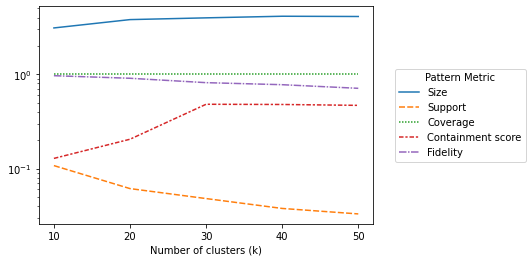

In [149]:
sizes = [3.1, 3.8, 3.966666666666667, 4.125, 4.1]
supports = [0.10742060920285157, 0.06125243033052495, 0.048012529704039755, 0.03772278029812054, 0.03300064808813999]
coverages = [1,1,1,1,1]
containments = [0.12805437298589745, 0.20454127252282145, 0.48045483709479553, 0.4779993863942532, 0.46782348290402626]
fidelities = [0.9654982817869415, 0.906626982327146, 0.8145276316821772, 0.7748987406294074, 0.7094345025847265]

plot_data_k = pd.DataFrame(data=np.array([sizes, supports, coverages, containments, fidelities]).T, 
                                     columns=['Size', 'Support', 'Coverage', 'Containment score', 'Fidelity'],
                                     index=[10,20,30,40,50])

ax = sb.lineplot(data=plot_data_k).axes
ax.set_xticks(plot_data_k.index)
ax.set_xlabel('Number of clusters (k)')
ax.legend(title='Pattern Metric', loc='center left', bbox_to_anchor=(1.05, 0.5))
ax.set_yscale('log')
plt.savefig('notebooks/effect_k.pdf', bbox_inches='tight')

## Effect of sample ratio

In [88]:
kmeans = KMeans(n_clusters=20).fit(compasX)
labels = kmeans.labels_

In [89]:
cluster_shap = sdc.explain_clustering_shap(kmeans, compasX, sample_frac=0.01, min_sample_size=5)
cluster_rules = sdc.patterns_from_cluster_shap(cluster_shap, compas, compasX, labels)
sdm.print_pattern_metrics(cluster_rules, compas, labels)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Pattern size:		4.0 (3 - 6)
Support:		0.05812540505508749 (0.004698639014906027 - 0.22926117952041478)
Coverage:		1.0
Containment scores:	0.1394992326691975 (0.0 - 0.6054888507718696)
Fidelity: 		0.9325741730956008 (0.48575305291723203 - 1.0)


In [90]:
cluster_shap = sdc.explain_clustering_shap(kmeans, compasX, sample_frac=0.1, min_sample_size=5)
cluster_rules = sdc.patterns_from_cluster_shap(cluster_shap, compas, compasX, labels)
sdm.print_pattern_metrics(cluster_rules, compas, labels)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Pattern size:		3.8 (3 - 5)
Support:		0.0604099157485418 (0.004698639014906027 - 0.2483797796500324)
Coverage:		1.0
Containment scores:	0.24689712222690754 (0.0 - 1.0)
Fidelity: 		0.9137917645392488 (0.48575305291723203 - 1.0)


In [91]:
cluster_shap = sdc.explain_clustering_shap(kmeans, compasX, sample_frac=0.2, min_sample_size=5)
cluster_rules = sdc.patterns_from_cluster_shap(cluster_shap, compas, compasX, labels)
sdm.print_pattern_metrics(cluster_rules, compas, labels)

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/122 [00:00<?, ?it/s]

  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Pattern size:		3.7 (2 - 6)
Support:		0.06505184705119896 (0.004698639014906027 - 0.22926117952041478)
Coverage:		1.0
Containment scores:	0.24614376718222628 (0.0 - 1.0)
Fidelity: 		0.8975673202510857 (0.296849087893864 - 1.0)


In [92]:
cluster_shap = sdc.explain_clustering_shap(kmeans, compasX, sample_frac=0.4, min_sample_size=5)
cluster_rules = sdc.patterns_from_cluster_shap(cluster_shap, compas, compasX, labels)
sdm.print_pattern_metrics(cluster_rules, compas, labels)

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/318 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/464 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

Pattern size:		3.7 (2 - 6)
Support:		0.06413642255346727 (0.004698639014906027 - 0.22926117952041478)
Coverage:		1.0
Containment scores:	0.25900870550174665 (0.0 - 1.0)
Fidelity: 		0.889990947423071 (0.4550561797752809 - 1.0)


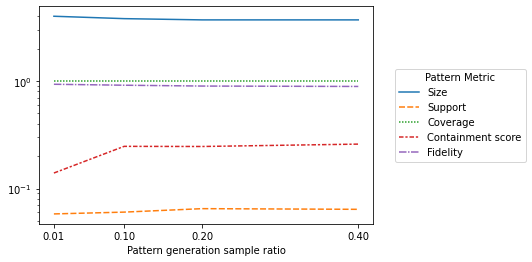

In [150]:
sizes = [4, 3.8, 3.7, 3.7]
supports = [0.05812540505508749, 0.0604099157485418, 0.06505184705119896, 0.06413642255346727]
coverages = [1,1,1,1]
containments = [0.1394992326691975, 0.24689712222690754, 0.24614376718222628, 0.25900870550174665]
fidelities = [0.9325741730956008, 0.9137917645392488, 0.8975673202510857, 0.889990947423071]

plot_data_sample_ratio = pd.DataFrame(data=np.array([sizes, supports, coverages, containments, fidelities]).T, 
                                     columns=['Size', 'Support', 'Coverage', 'Containment score', 'Fidelity'],
                                     index=[0.01, 0.1, 0.2, 0.4])

ax = sb.lineplot(data=plot_data_sample_ratio).axes
ax.set_xticks(plot_data_sample_ratio.index)
ax.set_xlabel('Pattern generation sample ratio')
ax.legend(title='Pattern Metric', loc='center left', bbox_to_anchor=(1.05, 0.5))
ax.set_yscale('log')
plt.savefig('notebooks/effect_sample_ratio.pdf', bbox_inches='tight')

## Effect of SHAP value threshold

In [68]:
kmeans = KMeans(n_clusters=20).fit(compasX)
labels = kmeans.labels_
cluster_shap = sdc.explain_clustering_shap(kmeans, compasX)

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [69]:
cluster_rules = sdc.patterns_from_cluster_shap(cluster_shap, compas, compasX, labels, shap_threshold=0.05)
sdm.print_pattern_metrics(cluster_rules, compas, labels)

Pattern size:		4.4 (3 - 7)
Support:		0.05634316267012314 (0.004698639014906027 - 0.22926117952041478)
Coverage:		1.0
Containment scores:	0.12544535907586035 (0.0 - 0.6547085201793722)
Fidelity: 		0.9229355834843254 (0.5333333333333333 - 1.0)


In [70]:
cluster_rules = sdc.patterns_from_cluster_shap(cluster_shap, compas, compasX, labels, shap_threshold=0.1)
sdm.print_pattern_metrics(cluster_rules, compas, labels)

Pattern size:		3.65 (3 - 5)
Support:		0.06248379779650033 (0.004698639014906027 - 0.2584251458198315)
Coverage:		1.0
Containment scores:	0.3498052643041916 (0.0 - 1.0)
Fidelity: 		0.8790551670572547 (0.4898236092265943 - 1.0)


In [71]:
cluster_rules = sdc.patterns_from_cluster_shap(cluster_shap, compas, compasX, labels, shap_threshold=0.15)
sdm.print_pattern_metrics(cluster_rules, compas, labels)

Pattern size:		2.7 (1 - 5)
Support:		0.08839922229423203 (0.005022683084899547 - 0.3723266364225535)
Coverage:		1.0
Containment scores:	0.7052550605191131 (0.2545691906005222 - 1.0)
Fidelity: 		0.7629441282898589 (0.2447457627118644 - 1.0)


In [72]:
cluster_rules = sdc.patterns_from_cluster_shap(cluster_shap, compas, compasX, labels, shap_threshold=0.2)
sdm.print_pattern_metrics(cluster_rules, compas, labels)

Pattern size:		2.05 (1 - 3)
Support:		0.13210466623460793 (0.005022683084899547 - 0.6432274789371355)
Coverage:		1.0
Containment scores:	0.8490307287531689 (0.371536523929471 - 1.0)
Fidelity: 		0.6528521823628703 (0.1470468431771894 - 1.0)


With increasing shap value threshold:
- pattern size decreases because more unimportant features are ignored
- support increases as the patterns are more general (less specific)
- containment increases as the pattern-induced subgroups have more overlap
- fidelity decreases as more general patterns do not reflect the cluster structure perfectly anymore

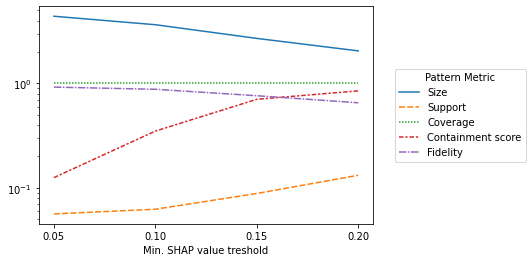

In [148]:
sizes = [4.4, 3.65, 2.7, 2.05]
supports = [0.05634316267012314, 0.06248379779650033, 0.08839922229423203, 0.13210466623460793]
coverages = [1,1,1,1]
containments = [0.12544535907586035, 0.3498052643041916, 0.7052550605191131, 0.8490307287531689]
fidelities = [0.9229355834843254, 0.8790551670572547, 0.7629441282898589, 0.6528521823628703]

plot_data_shap_threshold = pd.DataFrame(data=np.array([sizes, supports, coverages, containments, fidelities]).T, 
                                         columns=['Size', 'Support', 'Coverage', 'Containment score', 'Fidelity'],
                                         index=[0.05, 0.1, 0.15, 0.2])

ax = sb.lineplot(data=plot_data_shap_threshold).axes
ax.set_xticks(plot_data_shap_threshold.index)
ax.set_xlabel('Min. SHAP value treshold')
ax.legend(title='Pattern Metric', loc='center left', bbox_to_anchor=(1.05, 0.5))
ax.set_yscale('log')
plt.savefig('notebooks/effect_shap_threshold.pdf', bbox_inches='tight')

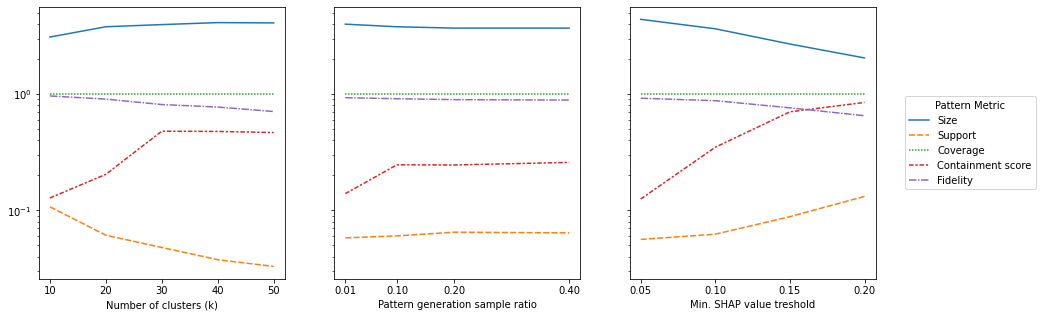

In [153]:
fig, axes = plt.subplots(1,3, sharey=True, figsize=(15,5))

sb.lineplot(data=plot_data_k, ax=axes[0], legend=False)
axes[0].set_xticks(plot_data_k.index)
axes[0].set_xlabel('Number of clusters (k)')

sb.lineplot(data=plot_data_sample_ratio, ax=axes[1], legend=False)
axes[1].set_xticks(plot_data_sample_ratio.index)
axes[1].set_xlabel('Pattern generation sample ratio')

sb.lineplot(data=plot_data_shap_threshold, ax=axes[2])
axes[2].set_xticks(plot_data_shap_threshold.index)
axes[2].set_xlabel('Min. SHAP value treshold')
axes[2].legend(title='Pattern Metric', loc='center left', bbox_to_anchor=(1.1, 0.5))
axes[2].set_yscale('log')
plt.savefig('notebooks/sacling_effects.pdf', bbox_inches='tight')

## LIME

In [16]:
from lime.lime_tabular import LimeTabularExplainer

In [19]:
kmeans = KMeans(n_clusters=20).fit(compasX)
labels = kmeans.predict(compasX)
n_clusters = labels.max() + 1

In [95]:
compasX

,age,priors_count,days_b_screening_arrest,jail_length_days,c_charge_degree#Misdemeanor,race#Asian,race#Caucasian,race#Hispanic,race#Native American,race#Other,sex#Male
0,0.653846,0.000000,0.483333,0.00125,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,0.205128,0.000000,0.483333,0.01375,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.076923,0.105263,0.483333,0.00250,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.333333,0.000000,0.500000,0.00250,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4,0.294872,0.368421,0.483333,0.00875,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
6167,0.064103,0.000000,0.483333,0.00250,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6168,0.064103,0.000000,0.483333,0.00250,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6169,0.500000,0.000000,0.483333,0.00250,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6170,0.192308,0.078947,0.483333,0.00250,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
data = compasX
n_feat = len(data.columns)
cat_feat = [i for i, col in enumerate(data.columns) if '#' in col]
explainer = LimeTabularExplainer(compasX.values, feature_names=compasX.columns, discretize_continuous=True,
                            categorical_features=cat_feat)

for c in range(0, n_clusters):
    indices = (labels == c).astype(int)
    clusterX = pd.DataFrame(data.values[indices.astype(bool)], columns=data.columns)
    samples = clusterX.sample(n=3)
    
    # Predict class ([0,1] or [1,0])
    f = lambda X: np.array([[0,1] if b else [1,0] for b in kmeans.predict(X) == c])
    
    # Explain sample instances of cluster c
    agg = np.zeros(n_feat)
    exps = []
    for _, row in samples.iterrows():
        exp = explainer.explain_instance(row, f)
        print(exp.as_list())
        for i, v in exp.local_exp[1]:
            agg[i] += v
        exps.append(exp)
    agg = agg / 3
    print(agg, np.where(agg > 0.1))
    idx = np.where(agg > 0.1)
    print(clusterX.columns[idx])
    for col in clusterX.columns[idx].values:
        print(col, np.unique(clusterX[col], return_counts=True))

[('race#Caucasian=1', 0.3538014425436482), ('c_charge_degree#Misdemeanor=0', 0.19453361153918), ('sex#Male=1', 0.1501701319254724), ('0.09 < age <= 0.17', 0.0815530628541274), ('race#Hispanic=0', 0.03866917767517022), ('race#Asian=0', -0.02590183047350296), ('race#Other=0', 0.018360800284389536), ('priors_count > 0.11', -0.01553337390681827), ('jail_length_days > 0.01', 0.008415882224361576), ('days_b_screening_arrest > 0.48', 0.00654919039565462)]
[('race#Caucasian=1', 0.34297579697523445), ('c_charge_degree#Misdemeanor=0', 0.18040496572920892), ('sex#Male=1', 0.1437680362674674), ('0.09 < age <= 0.17', 0.0898940588591123), ('race#Native American=0', -0.08735567053238023), ('race#Other=0', 0.0416254266161491), ('race#Hispanic=0', 0.010458099009377605), ('race#Asian=0', 0.005133138301806587), ('days_b_screening_arrest > 0.48', 0.0019292724813754455), ('0.00 < jail_length_days <= 0.00', 0.001819188235327484)]
[('race#Caucasian=1', 0.36604919883492976), ('c_charge_degree#Misdemeanor=0', 

In [101]:
c = 2
f = lambda X: np.array([[0,1] if b else [1,0] for b in kmeans.predict(X) == c])
exp = explainer.explain_instance(compasX.iloc[15], f)
exp.show_in_notebook(show_table=True, show_all=False)return_counts=

In [102]:
exp.local_exp

{1: [(10, -0.37314913839229574),
  (6, -0.11055845186987694),
  (4, 0.10269316303449111),
  (9, 0.07609547058691223),
  (7, 0.06844810633796344),
  (5, -0.04515967748940391),
  (2, -0.01076960207063742),
  (3, -0.009205062381443689),
  (1, 0.007780514569045594),
  (8, -0.0032204525533197133)]}

In [103]:
exp.as_list()

[('sex#Male=1', -0.37314913839229574),
 ('race#Caucasian=1', -0.11055845186987694),
 ('c_charge_degree#Misdemeanor=0', 0.10269316303449111),
 ('race#Other=0', 0.07609547058691223),
 ('race#Hispanic=0', 0.06844810633796344),
 ('race#Asian=0', -0.04515967748940391),
 ('days_b_screening_arrest <= 0.48', -0.01076960207063742),
 ('0.00 < jail_length_days <= 0.00', -0.009205062381443689),
 ('priors_count > 0.11', 0.007780514569045594),
 ('race#Native American=0', -0.0032204525533197133)]

In [108]:
exp.

[1]

In [78]:
for f_idx, val in exp.local_exp[1]:
    print(compasX.columns[f_idx], val)

c_charge_degree#Misdemeanor -0.27713024583080564
race#Caucasian -0.14323509263664083
race#Native American -0.1158743033482349
race#Other 0.1035514857424647
race#Hispanic 0.08820806942785207
age 0.05928832301298742
priors_count -0.03728411128904025
race#Asian -0.014703312312518466
days_b_screening_arrest -0.008803878086358819
jail_length_days 0.0026221471378478733


# South german credit

## Load dataset

In [13]:
credit_path = 'data/SouthGermanCredit.asc'
credit = pd.read_csv(credit_path, sep=' ')
credit = credit.rename(columns={"kredit": "class"})
categ_columns = ['laufkont', 'moral', 'verw', 'sparkont', 'beszeit', 'rate', 'famges', 'buerge', 'wohnzeit', 'verm', 'weitkred', 'wohn', 'bishkred', 'beruf', 'pers', 'telef', 'gastarb']
credit

,laufkont,laufzeit,moral,verw,hoehe,sparkont,beszeit,rate,famges,buerge,...,verm,alter,weitkred,wohn,bishkred,beruf,pers,telef,gastarb,class
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,24,2,3,1987,1,3,2,3,1,...,1,21,3,1,1,2,1,1,2,0
996,1,24,2,0,2303,1,5,4,3,2,...,1,45,3,2,1,3,2,1,2,0
997,4,21,4,0,12680,5,5,4,3,1,...,4,30,3,3,1,4,2,2,2,0
998,2,12,2,3,6468,5,1,2,3,1,...,4,52,3,2,1,4,2,2,2,0


In [14]:
credit['out'] = 0
creditX = sdu.prepare(credit, categ_columns=categ_columns)

## Train classifier

In [15]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, average_precision_score
from sklearn.model_selection import train_test_split

y = credit['class']
trainX, testX, trainY, testY = train_test_split(creditX, y, test_size=0.2)

train_data = lgb.Dataset(trainX, label=trainY)
test_data = lgb.Dataset(testX, label=testY)
train_data.data.shape, test_data.data.shape

((800, 54), (200, 54))

In [16]:
def print_pred(model, is_prob=False):
    y_pred = model.predict(testX)
    auc = roc_auc_score(testY, y_pred)
    avg_prec = average_precision_score(testY, y_pred)

    print(f"AUC: {auc}")
    print(f"Average Precision Score: {avg_prec}")

    if not is_prob:
        acc = accuracy_score(testY, y_pred)
        f1 = f1_score(testY, y_pred)

        print(f"Accuracy: {acc}")
        print(f"F1: {f1}")

[LightGBM] [Info] Number of positive: 565, number of negative: 235
[LightGBM] [Info] Total Bins 430
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.706250 -> initscore=0.877240
[LightGBM] [Info] Start training from score 0.877240
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 15 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's auc: 0.738462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	valid_0's auc: 0.757379
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

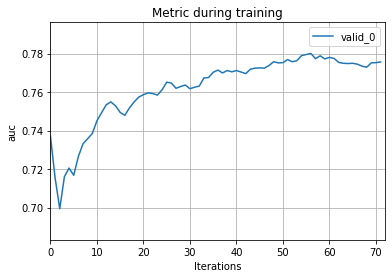

In [17]:
params = {'objective' : 'binary',
          'metric' : 'auc',
          'boosting_type' : 'gbdt',
          'colsample_bytree' : 0.92,
#           'max_depth' : -1,
#           'n_estimators' : 200,
          'min_child_samples': 20, 
#           'min_child_weight': 0.1,
          'subsample': 0.85,
#           'verbose' : -1,
          'num_threads' : 4,    # number of real cores
          'feature_pre_filter': False,
          'force_row_wise': True    # suppress warning
}

num_round = 100
eval_result = {}

lgbm = lgb.train(params,
                 train_data,
                 num_boost_round=num_round,
                 valid_sets=test_data,
                 # verbose_eval= 30
                 callbacks=[
                     lgb.early_stopping(stopping_rounds=15),
                     lgb.log_evaluation(period=10),
                     lgb.record_evaluation(eval_result)
                 ])

g = lgb.plot_metric(eval_result)

'Max accuracy for classification threshold 0.61 is 0.938'

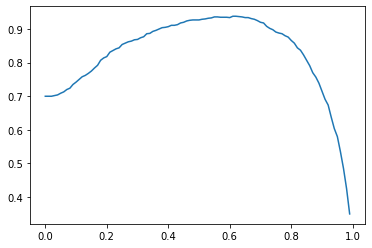

In [18]:
prediction = lgbm.predict(creditX)
thresholds = np.arange(0.0, 1.0, 0.01)

acc = np.zeros(len(thresholds))
max_acc = 0
best_thresh = 0
for i, clsf_thresh in enumerate(thresholds):
    vfunc = np.vectorize(lambda x: 1.0 if x > clsf_thresh else 0.0)
    temp = vfunc(prediction)
    acc[i] = accuracy_score(y, temp)
    if max_acc < acc[i]:
        max_acc = acc[i]
        best_thresh = clsf_thresh
    
plt.plot(thresholds, acc)

f'Max accuracy for classification threshold {best_thresh} is {max_acc}'

In [19]:
vfunc = np.vectorize(lambda x: 1.0 if x > best_thresh else 0.0)
credit['out'] = vfunc(prediction)

## k-Means

In [113]:
kmeans = KMeans(n_clusters=10).fit(creditX)
labels = kmeans.labels_
cluster_shap = sdc.explain_clustering_shap(kmeans, creditX, sample_frac=0.05)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [114]:
cluster_rules = sdc.patterns_from_cluster_shap(cluster_shap, credit, creditX, labels)
res = sdf.test_model_fairness(credit, None, labels)
P = sdm.subgroups_to_cluster_patterns(res.subgroups)
cluster_rules

{0: [('beruf', '=', 2), ('beruf', '!=', 3)],
 1: [('moral', '!=', 2), ('moral', '=', 4), ('beszeit', '=', 3)],
 2: [('famges', '!=', 3), ('wohnzeit', '=', 2)],
 3: [('beruf', '!=', 3), ('beruf', '=', 4), ('telef', '=', 2)],
 4: [('famges', '!=', 3)],
 5: [('beszeit', '=', 4), ('famges', '=', 3)],
 6: [('famges', '=', 3), ('beruf', '=', 2), ('beruf', '!=', 3)],
 7: [('verm', '=', 4), ('wohn', '!=', 2), ('wohn', '=', 3)],
 8: [('beszeit', '=', 5)],
 9: [('beszeit', '=', 3)]}

In [115]:
P

{0: [('moral', '=', 2.0),
  ('buerge', '=', 1.0),
  ('weitkred', '=', 3.0),
  ('wohn', '=', 2.0),
  ('bishkred', '=', 1.0),
  ('beruf', '=', 2.0),
  ('pers', '=', 2.0),
  ('gastarb', '=', 2.0)],
 1: [('moral', '=', 4.0),
  ('buerge', '=', 1.0),
  ('weitkred', '=', 3.0),
  ('bishkred', '=', 2.0),
  ('beruf', '=', 3.0),
  ('pers', '=', 2.0),
  ('gastarb', '=', 2.0),
  ('beszeit', '=', 3.0)],
 2: [('moral', '=', 2.0),
  ('buerge', '=', 1.0),
  ('weitkred', '=', 3.0),
  ('wohn', '=', 2.0),
  ('bishkred', '=', 1.0),
  ('pers', '=', 2.0),
  ('gastarb', '=', 2.0),
  ('famges', '=', 2.0),
  ('wohnzeit', '=', 2.0)],
 3: [('buerge', '=', 1.0),
  ('wohn', '=', 2.0),
  ('bishkred', '=', 1.0),
  ('beruf', '=', 4.0),
  ('pers', '=', 2.0),
  ('gastarb', '=', 2.0),
  ('telef', '=', 2.0)],
 4: [('moral', '=', 2.0),
  ('buerge', '=', 1.0),
  ('weitkred', '=', 3.0),
  ('bishkred', '=', 1.0),
  ('beruf', '=', 3.0),
  ('pers', '=', 2.0),
  ('gastarb', '=', 2.0),
  ('famges', '=', 2.0)],
 5: [('buerge', '='

In [116]:
sdm.print_pattern_metrics(P, credit, labels), sdm.print_pattern_metrics(cluster_rules, credit, labels)

Pattern size:		7.9 (7 - 9)
Support:		0.041199999999999994 (0.024 - 0.085)
Coverage:		0.381
Containment scores:	0.12587623834216374 (0.0 - 0.5833333333333334)
Fidelity: 		0.8840332296919741 (0.5675675675675675 - 1.0)
Pattern size:		2.1 (1 - 3)
Support:		0.19039999999999999 (0.084 - 0.452)
Coverage:		0.965
Containment scores:	0.5650044164773532 (0.16666666666666666 - 1.0)
Fidelity: 		0.5578495083505858 (0.24188790560471976 - 0.9805825242718447)


(None, None)

In [117]:
sdm.cluster_pattern_jaccard(cluster_rules, P), sdm.cluster_pattern_avg_jaccard(cluster_rules, P)

({0: 0.1111111111111111,
  1: 0.2222222222222222,
  2: 0.1,
  3: 0.25,
  4: 0.0,
  5: 0.25,
  6: 0.25,
  7: 0.25,
  8: 0.125,
  9: 0.1111111111111111},
 0.16694444444444445)

## Other

In [111]:
spectral = SpectralClustering(n_clusters=10).fit(creditX)
np.unique(spectral.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([242,   2,  91, 232,   5, 296,  16,   2,   2, 112], dtype=int64))

# MEPS
## Load dataset

In [190]:
path = 'data/meps19.csv'
meps_orig = pd.read_csv(path, index_col=0)
label_column = 'UTILIZATION'
meps_orig = meps_orig.rename(columns={label_column: 'class'})

mepsX = meps_orig.drop(columns='class')
mepsX

,AGE,RACE,PCS42,MCS42,K6SUM42,REGION=1,REGION=2,REGION=3,REGION=4,SEX=1,...,EMPST=3,EMPST=4,POVCAT=1,POVCAT=2,POVCAT=3,POVCAT=4,POVCAT=5,INSCOV=1,INSCOV=2,INSCOV=3
0,53.0,1.0,25.93,58.47,3.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,56.0,1.0,20.42,26.57,17.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,23.0,1.0,53.12,50.33,7.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,3.0,1.0,-1.00,-1.00,-1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5,27.0,0.0,-1.00,-1.00,-1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16573,25.0,0.0,56.71,62.39,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
16574,25.0,0.0,56.71,62.39,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
16575,2.0,1.0,-1.00,-1.00,-1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16576,54.0,0.0,43.97,42.45,24.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Train classifier

In [191]:
y = meps_orig['class']
X = mepsX
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2)

train_data = lgb.Dataset(trainX, label=trainY)
test_data = lgb.Dataset(testX, label=testY)
train_data.data.shape, test_data.data.shape

((12664, 138), (3166, 138))

In [192]:
def print_pred(model, is_prob=False):
    y_pred = model.predict(testX)
    auc = roc_auc_score(testY, y_pred)
    avg_prec = average_precision_score(testY, y_pred)

    print(f"AUC: {auc}")
    print(f"Average Precision Score: {avg_prec}")

    if not is_prob:
        acc = accuracy_score(testY, y_pred)
        f1 = f1_score(testY, y_pred)

        print(f"Accuracy: {acc}")
        print(f"F1: {f1}")

[LightGBM] [Info] Number of positive: 2153, number of negative: 10511
[LightGBM] [Info] Total Bins 891
[LightGBM] [Info] Number of data points in the train set: 12664, number of used features: 138
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.170009 -> initscore=-1.585560
[LightGBM] [Info] Start training from score -1.585560
Training until validation scores don't improve for 15 rounds
[10]	valid_0's auc: 0.854181
[20]	valid_0's auc: 0.859905
[30]	valid_0's auc: 0.862606
[40]	valid_0's auc: 0.864645
[50]	valid_0's auc: 0.865511
[60]	valid_0's auc: 0.865051
Early stopping, best iteration is:
[47]	valid_0's auc: 0.86556


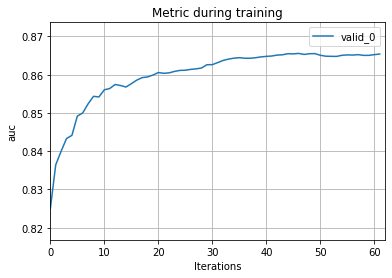

In [193]:
params = {'objective' : 'binary',
          'metric' : 'auc',
          'boosting_type' : 'gbdt',
          'colsample_bytree' : 0.92,
#           'max_depth' : -1,
#           'n_estimators' : 200,
          'min_child_samples': 20, 
#           'min_child_weight': 0.1,
          'subsample': 0.85,
#           'verbose' : -1,
          'num_threads' : 4,    # number of real cores
          'feature_pre_filter': False,
          'force_row_wise': True    # suppress warning
}

num_round = 100
eval_result = {}

lgbm = lgb.train(params,
                 train_data,
                 num_boost_round=num_round,
                 valid_sets=test_data,
                 # verbose_eval= 30
                 callbacks=[
                     lgb.early_stopping(stopping_rounds=15),
                     lgb.log_evaluation(period=10),
                     lgb.record_evaluation(eval_result)
                 ])

g = lgb.plot_metric(eval_result)

'Max accuracy for classification threshold 0.46 is 0.891282375236892'

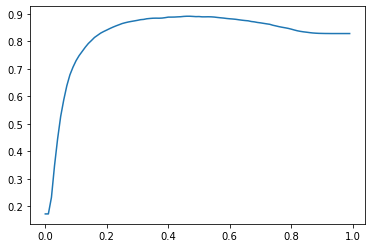

In [194]:
prediction = lgbm.predict(X)
thresholds = np.arange(0.0, 1.0, 0.01)

acc = np.zeros(len(thresholds))
max_acc = 0
best_thresh = 0
for i, clsf_thresh in enumerate(thresholds):
    vfunc = np.vectorize(lambda x: 1.0 if x > clsf_thresh else 0.0)
    temp = vfunc(prediction)
    acc[i] = accuracy_score(y, temp)
    if max_acc < acc[i]:
        max_acc = acc[i]
        best_thresh = clsf_thresh
    
plt.plot(thresholds, acc)

vfunc = np.vectorize(lambda x: 1.0 if x > best_thresh else 0.0)
out_column = vfunc(prediction)

f'Max accuracy for classification threshold {best_thresh} is {max_acc}'

## Undummify

In [196]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    categ_cols = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            categ_cols.append(col)
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df, categ_cols

meps, categ_cols = undummify(meps_orig, prefix_sep='=')
meps['out'] = out_column

## k-Means

sil        0.412745
dbi        0.974381
chi    29917.063590
dtype: float64 1704945.1422095257
sil        0.310355
dbi        1.046940
chi    23332.396750
dtype: float64 1057940.7183002175
sil        0.275766
dbi        1.090093
chi    19596.544842
dtype: float64 831056.820158399
sil        0.262518
dbi        1.137417
chi    17254.839122
dtype: float64 704360.5898113481
sil        0.254242
dbi        1.180202
chi    15439.817540
dtype: float64 627717.4289415532
sil        0.186672
dbi        1.346086
chi    10757.407044
dtype: float64 447176.4421605469


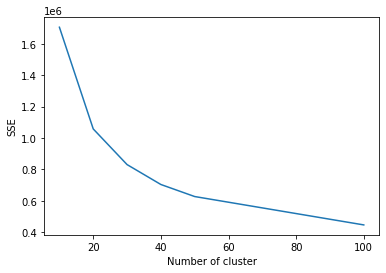

In [209]:
sse = {}
for k in [10,20,30,40,50, 100]:
    kmeans = KMeans(n_clusters=k).fit(mepsX)
    labels = kmeans.labels_
    print(sdc.validate_clustering(mepsX, labels))
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [210]:
kmeans = KMeans(n_clusters=30).fit(mepsX)
labels = kmeans.labels_

In [211]:
cluster_shap = sdc.explain_clustering_shap(kmeans, mepsX, sample_frac=0.05)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [212]:
cluster_rules = sdc.patterns_from_cluster_shap(cluster_shap, meps, mepsX, labels)
res = sdf.test_model_fairness(meps, None, labels, categ_columns=categ_cols)
P = sdm.subgroups_to_cluster_patterns(res.subgroups)
cluster_rules

{0: [('AGE', '>=', 13.0),
  ('AGE', '<=', 20.0),
  ('PCS42', '<=', -1.0),
  ('MCS42', '<=', -1.0)],
 1: [('AGE', '>=', 31.0),
  ('AGE', '<=', 44.0),
  ('PCS42', '>=', 43.52),
  ('PCS42', '<=', 63.66),
  ('MCS42', '>=', 39.71),
  ('MCS42', '<=', 55.37)],
 2: [('AGE', '>=', 42.0),
  ('AGE', '<=', 75.0),
  ('PCS42', '<=', 32.28),
  ('MCS42', '>=', 47.6)],
 3: [('AGE', '>=', 60.0),
  ('AGE', '<=', 74.0),
  ('PCS42', '>=', 46.85),
  ('PCS42', '<=', 61.25),
  ('MCS42', '>=', 46.08),
  ('MCS42', '<=', 66.34)],
 4: [('AGE', '>=', 50.0),
  ('AGE', '<=', 66.0),
  ('PCS42', '<=', -1.0),
  ('MCS42', '<=', 29.01)],
 5: [('AGE', '<=', 5.0), ('PCS42', '=', -1.0), ('MCS42', '=', -1.0)],
 6: [('AGE', '>=', 18.0),
  ('AGE', '<=', 44.0),
  ('PCS42', '>=', 16.31),
  ('PCS42', '<=', 47.03),
  ('MCS42', '>=', 21.44),
  ('MCS42', '<=', 52.97)],
 7: [('AGE', '>=', 65.0),
  ('PCS42', '>=', 14.31),
  ('PCS42', '<=', 47.76),
  ('MCS42', '>=', 18.76),
  ('MCS42', '<=', 48.98)],
 8: [('AGE', '>=', 37.0),
  ('AGE',

In [213]:
P

{0: [('PCS42', '=', -1.0),
  ('MCS42', '=', -1.0),
  ('K6SUM42', '=', -1.0),
  ('MARRY', '=', '6'),
  ('FTSTU', '=', '-1'),
  ('RTHLTH', '=', '1'),
  ('HIBPDX', '=', '-1'),
  ('CHDDX', '=', '-1'),
  ('ANGIDX', '=', '-1'),
  ('MIDX', '=', '-1'),
  ('OHRTDX', '=', '-1'),
  ('STRKDX', '=', '-1'),
  ('EMPHDX', '=', '-1'),
  ('CHBRON', '=', '-1'),
  ('CHOLDX', '=', '-1'),
  ('CANCERDX', '=', '-1'),
  ('DIABDX', '=', '-1'),
  ('JTPAIN', '=', '-1'),
  ('ARTHDX', '=', '-1'),
  ('ARTHTYPE', '=', '-1'),
  ('ASTHDX', '=', '2'),
  ('ADHDADDX', '=', '2'),
  ('PREGNT', '=', '-1'),
  ('WLKLIM', '=', '2'),
  ('ACTLIM', '=', '2'),
  ('SOCLIM', '=', '2'),
  ('COGLIM', '=', '-1'),
  ('DFHEAR42', '=', '2'),
  ('DFSEE42', '=', '2'),
  ('ADSMOK42', '=', '-1'),
  ('PHQ242', '=', '-1')],
 1: [('MARRY', '=', '1'),
  ('FTSTU', '=', '-1'),
  ('HIBPDX', '=', '2'),
  ('CHDDX', '=', '2'),
  ('ANGIDX', '=', '2'),
  ('MIDX', '=', '2'),
  ('OHRTDX', '=', '2'),
  ('STRKDX', '=', '2'),
  ('EMPHDX', '=', '2'),
  ('CHBRON

In [214]:
sdm.print_pattern_metrics(P, meps, labels), sdm.print_pattern_metrics(cluster_rules, meps, labels)

Pattern size:		23.866666666666667 (10 - 33)
Support:		0.06280058959781006 (0.0025900189513581805 - 0.2991156032849021)
Coverage:		0.6651926721415035
Containment scores:	0.8719339706856043 (0.0 - 1.0)
Fidelity: 		0.26425404797161167 (0.011404435058078142 - 1.0)
Pattern size:		5.233333333333333 (3 - 6)
Support:		0.044828384923141715 (0.01080227416298168 - 0.11800379027163613)
Coverage:		1.0
Containment scores:	0.21200975870137878 (0.0 - 0.4371584699453552)
Fidelity: 		0.7019210640211393 (0.31420765027322406 - 1.0)


(None, None)

In [215]:
sdm.cluster_pattern_jaccard(cluster_rules, P), sdm.cluster_pattern_avg_jaccard(cluster_rules, P)

({0: 0.0,
  1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.058823529411764705,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  10: 0.0,
  11: 0.0,
  12: 0.0,
  13: 0.0,
  14: 0.05714285714285714,
  15: 0.0,
  16: 0.0,
  17: 0.0,
  18: 0.0,
  19: 0.0,
  20: 0.0,
  21: 0.0,
  22: 0.0,
  23: 0.0,
  24: 0.0,
  25: 0.0,
  26: 0.0,
  27: 0.0,
  28: 0.0,
  29: 0.0},
 0.003865546218487395)

## DBCSAN

In [238]:
dbscan = DBSCAN(eps=7.5).fit(mepsX)
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17], dtype=int64),
 array([ 411, 9042,   23, 6235,    4,    8,   11,   34,    3,    7,    8,
           7,    5,    6,    6,    7,    4,    5,    4], dtype=int64))

In [240]:
cluster_shap = sdc.explain_clustering_shap(dbscan, mepsX, sample_frac=0.01)

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/62 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [241]:
labels = dbscan.labels_
cluster_rules = sdc.patterns_from_cluster_shap(cluster_shap, meps, mepsX, labels)
res = sdf.test_model_fairness(meps, None, labels, categ_columns=categ_cols)
P = sdm.subgroups_to_cluster_patterns(res.subgroups)
cluster_rules

{0: [('PCS42', '>=', 8.81),
  ('PCS42', '<=', 68.18),
  ('MCS42', '>=', 17.78),
  ('MCS42', '<=', 72.84)],
 1: [('AGE', '>=', 52.0),
  ('AGE', '<=', 63.0),
  ('PCS42', '>=', 20.42),
  ('PCS42', '<=', 30.12),
  ('MCS42', '>=', 14.34),
  ('MCS42', '<=', 26.73),
  ('K6SUM42', '>=', 14.0)],
 2: [('PCS42', '=', -1.0), ('MCS42', '=', -1.0)],
 3: [('AGE', '>=', 67.0),
  ('AGE', '<=', 72.0),
  ('PCS42', '>=', 29.58),
  ('PCS42', '<=', 33.51),
  ('MCS42', '>=', 21.74),
  ('MCS42', '<=', 27.92),
  ('K6SUM42', '>=', 14.0),
  ('K6SUM42', '<=', 18.0)],
 4: [('AGE', '>=', 80.0),
  ('PCS42', '>=', 27.53),
  ('PCS42', '<=', 33.36),
  ('MCS42', '>=', 23.0),
  ('MCS42', '<=', 27.54),
  ('K6SUM42', '>=', 10.0),
  ('K6SUM42', '<=', 19.0)],
 5: [('AGE', '>=', 45.0),
  ('AGE', '<=', 64.0),
  ('PCS42', '=', -9.0),
  ('MCS42', '=', -9.0)],
 6: [('AGE', '>=', 33.0),
  ('AGE', '<=', 52.0),
  ('PCS42', '>=', 44.44),
  ('PCS42', '<=', 59.4),
  ('MCS42', '>=', 32.08),
  ('MCS42', '<=', 56.04),
  ('K6SUM42', '=', -

In [242]:
P

{0: [('MARRY', '=', '1'),
  ('FTSTU', '=', '-1'),
  ('ACTDTY', '=', '2'),
  ('HONRDC', '=', '2'),
  ('CHDDX', '=', '2'),
  ('ANGIDX', '=', '2'),
  ('MIDX', '=', '2'),
  ('OHRTDX', '=', '2'),
  ('STRKDX', '=', '2'),
  ('EMPHDX', '=', '2'),
  ('CHBRON', '=', '2'),
  ('CANCERDX', '=', '2'),
  ('DIABDX', '=', '2'),
  ('JTPAIN', '=', '2'),
  ('ARTHTYPE', '=', '-1'),
  ('ASTHDX', '=', '2'),
  ('ADHDADDX', '=', '-1'),
  ('PREGNT', '=', '-1'),
  ('WLKLIM', '=', '2'),
  ('ACTLIM', '=', '2'),
  ('SOCLIM', '=', '2'),
  ('COGLIM', '=', '2'),
  ('DFHEAR42', '=', '2'),
  ('DFSEE42', '=', '2'),
  ('ADSMOK42', '=', '2'),
  ('PHQ242', '=', '0'),
  ('EMPST', '=', '1')],
 1: [('FTSTU', '=', '-1'),
  ('HONRDC', '=', '2'),
  ('MIDX', '=', '2'),
  ('JTPAIN', '=', '1'),
  ('ADHDADDX', '=', '-1'),
  ('PREGNT', '=', '-1'),
  ('ACTLIM', '=', '1'),
  ('PHQ242', '=', '6'),
  ('EMPST', '=', '4'),
  ('HIBPDX', '=', '1'),
  ('INSCOV', '=', '2')],
 2: [('MARRY', '=', '6'),
  ('FTSTU', '=', '-1'),
  ('ACTDTY', '=', '3

In [243]:
sdm.print_pattern_metrics(P, meps, labels), sdm.print_pattern_metrics(cluster_rules, meps, labels)

Pattern size:		20.666666666666668 (11 - 30)
Support:		0.028490208464939985 (0.0003790271636133923 - 0.21775110549589388)
Coverage:		0.4495893872394188
Containment scores:	0.4448275155091133 (0.0 - 1.0)
Fidelity: 		0.3211520718631349 (0.001450536698578474 - 1.0)
Pattern size:		6.333333333333333 (2 - 8)
Support:		0.05572752158349126 (0.00018951358180669615 - 0.5996209728363866)
Coverage:		0.9958307012002526
Containment scores:	0.7062350751510044 (0.0 - 1.0)
Fidelity: 		0.9578087885610009 (0.75 - 1.0)


(None, None)

In [244]:
sdm.cluster_pattern_jaccard(cluster_rules, P), sdm.cluster_pattern_avg_jaccard(cluster_rules, P)

({0: 0.0,
  1: 0.0,
  2: 0.07142857142857142,
  3: 0.0,
  4: 0.0,
  5: 0.07692307692307693,
  6: 0.03333333333333333,
  7: 0.03333333333333333,
  8: 0.0,
  9: 0.0625,
  10: 0.07142857142857142,
  11: 0.045454545454545456,
  12: 0.0,
  13: 0.030303030303030304,
  14: 0.0,
  15: 0.0,
  16: 0.0,
  17: 0.05263157894736842},
 0.02651866895287948)

## SLINK

In [250]:
slink = AgglomerativeClustering(linkage='single', n_clusters=100).fit(mepsX)
labels = slink.labels_
np.unique(labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
       dtype=int64),
 array([9315,  126,    3,    2,    3,    2,   25,    3,    2,    2,    2,
           2,    1,    8,    2,    2,    3,    2,    1,    1,    2,    4,
           3,    1,    1,    1,    1,    1,    1,    1,    1,    2,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    2,    1,
           1,    1,    2,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1

In [251]:
spectral = SpectralClustering(n_clusters=20).fit(mepsX)
labels = spectral.labels_
np.unique(labels, return_counts=True)

KeyboardInterrupt: 

## Birch

In [253]:
birch = Birch(n_clusters=30).fit(mepsX)
np.unique(birch.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int64),
 array([ 353,  395,  514,  714,  294, 2724,  275,  177,  824,  303,  186,
         129,  900,  630,  252,  170,  137, 1750,  742,  114,  678,  619,
         355,  383,  391,  173,  391,  687,  298,  272], dtype=int64))

In [254]:
cluster_shap = sdc.explain_clustering_shap(birch, mepsX, sample_frac=0.01)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [255]:
labels = birch.labels_
cluster_rules = sdc.patterns_from_cluster_shap(cluster_shap, meps, mepsX, labels)
res = sdf.test_model_fairness(meps, None, labels, categ_columns=categ_cols)
P = sdm.subgroups_to_cluster_patterns(res.subgroups)
cluster_rules

{0: [('AGE', '>=', 57.0), ('PCS42', '<=', -1.0), ('MCS42', '<=', -1.0)],
 1: [('AGE', '>=', 18.0),
  ('AGE', '<=', 53.0),
  ('PCS42', '>=', 10.86),
  ('PCS42', '<=', 50.51),
  ('MCS42', '>=', 47.74),
  ('MCS42', '<=', 72.56)],
 2: [('AGE', '>=', 51.0),
  ('PCS42', '>=', 25.15),
  ('PCS42', '<=', 52.35),
  ('MCS42', '>=', 39.34),
  ('MCS42', '<=', 70.29)],
 3: [('AGE', '>=', 18.0),
  ('AGE', '<=', 42.0),
  ('PCS42', '>=', 39.34),
  ('MCS42', '>=', 18.14),
  ('MCS42', '<=', 54.5)],
 4: [('AGE', '>=', 18.0),
  ('AGE', '<=', 43.0),
  ('PCS42', '>=', 16.31),
  ('PCS42', '<=', 52.64),
  ('MCS42', '>=', 23.76),
  ('MCS42', '<=', 56.05)],
 5: [('AGE', '<=', 12.0), ('PCS42', '=', -1.0), ('MCS42', '=', -1.0)],
 6: [('AGE', '>=', 63.0),
  ('PCS42', '<=', 45.37),
  ('MCS42', '>=', 45.48),
  ('MCS42', '<=', 74.98)],
 7: [('AGE', '>=', 31.0),
  ('AGE', '<=', 73.0),
  ('PCS42', '<=', 35.65),
  ('MCS42', '>=', 29.01)],
 8: [('AGE', '>=', 22.0),
  ('AGE', '<=', 40.0),
  ('PCS42', '>=', 45.12),
  ('PCS4

In [256]:
P

{0: [('PCS42', '=', -1.0),
  ('MCS42', '=', -1.0),
  ('K6SUM42', '=', -1.0),
  ('MARRY', '=', '1'),
  ('FTSTU', '=', '-1'),
  ('ACTDTY', '=', '4'),
  ('HONRDC', '=', '2'),
  ('CHDDX', '=', '2'),
  ('ANGIDX', '=', '2'),
  ('MIDX', '=', '2'),
  ('STRKDX', '=', '2'),
  ('EMPHDX', '=', '2'),
  ('CHBRON', '=', '2'),
  ('ASTHDX', '=', '2'),
  ('ADHDADDX', '=', '-1'),
  ('PREGNT', '=', '-1'),
  ('WLKLIM', '=', '2'),
  ('ACTLIM', '=', '2'),
  ('SOCLIM', '=', '2'),
  ('COGLIM', '=', '2'),
  ('DFHEAR42', '=', '2'),
  ('DFSEE42', '=', '2'),
  ('ADSMOK42', '=', '-1'),
  ('PHQ242', '=', '-1'),
  ('EMPST', '=', '4')],
 1: [('MARRY', '=', '1'),
  ('FTSTU', '=', '-1'),
  ('ACTDTY', '=', '2'),
  ('HONRDC', '=', '2'),
  ('CHDDX', '=', '2'),
  ('ANGIDX', '=', '2'),
  ('MIDX', '=', '2'),
  ('STRKDX', '=', '2'),
  ('EMPHDX', '=', '2'),
  ('CHBRON', '=', '2'),
  ('ASTHDX', '=', '2'),
  ('ADHDADDX', '=', '-1'),
  ('WLKLIM', '=', '2'),
  ('ACTLIM', '=', '2'),
  ('SOCLIM', '=', '2'),
  ('COGLIM', '=', '2'),
  

In [257]:
sdm.print_pattern_metrics(P, meps, labels), sdm.print_pattern_metrics(cluster_rules, meps, labels)

Pattern size:		23.433333333333334 (10 - 34)
Support:		0.06325542219414614 (0.002653190145293746 - 0.31838281743524954)
Coverage:		0.6655716993051168
Containment scores:	0.8773377823173121 (0.45403225806451614 - 1.0)
Fidelity: 		0.25250116068984435 (0.010103845074375527 - 1.0)
Pattern size:		5.3 (3 - 7)
Support:		0.0763781848810276 (0.01831964624131396 - 0.2951358180669615)
Coverage:		1.0
Containment scores:	0.5567102181281565 (0.15321477428180574 - 1.0)
Fidelity: 		0.4517966136027187 (0.1348458904109589 - 0.9413333333333334)


(None, None)

In [258]:
sdm.cluster_pattern_jaccard(cluster_rules, P), sdm.cluster_pattern_avg_jaccard(cluster_rules, P)

({0: 0.0,
  1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.06060606060606061,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  10: 0.0,
  11: 0.0,
  12: 0.0,
  13: 0.0,
  14: 0.0,
  15: 0.0,
  16: 0.0,
  17: 0.05555555555555555,
  18: 0.0,
  19: 0.0,
  20: 0.0,
  21: 0.0,
  22: 0.0,
  23: 0.0,
  24: 0.0,
  25: 0.0,
  26: 0.0,
  27: 0.0,
  28: 0.0,
  29: 0.0},
 0.003872053872053872)

## Ward

In [259]:
ward = AgglomerativeClustering(linkage='ward', n_clusters=30).fit(mepsX)
np.unique(ward.labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int64),
 array([1622,  272,  353,  229,  793,  546,  137,  345,  953,  170,  326,
         303,  621,  260,  173,  555,  458,  248,  610,  373,  480,  669,
         186,   85,  164,  296,  129, 1671, 1068, 1735], dtype=int64))

In [260]:
cluster_shap = sdc.explain_clustering_shap(ward, mepsX, sample_frac=0.01, min_sample_size=5)

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

In [261]:
labels = ward.labels_
cluster_rules = sdc.patterns_from_cluster_shap(cluster_shap, meps, mepsX, labels)
res = sdf.test_model_fairness(meps, None, labels, categ_columns=categ_cols)
P = sdm.subgroups_to_cluster_patterns(res.subgroups)
cluster_rules

{0: [('AGE', '>=', 18.0),
  ('AGE', '<=', 37.0),
  ('PCS42', '>=', 35.74),
  ('PCS42', '<=', 61.0),
  ('MCS42', '>=', 46.92),
  ('MCS42', '<=', 70.29)],
 1: [('AGE', '>=', 18.0),
  ('AGE', '<=', 66.0),
  ('PCS42', '>=', 43.98),
  ('MCS42', '<=', 42.95)],
 2: [('AGE', '>=', 57.0), ('PCS42', '<=', -1.0), ('MCS42', '<=', -1.0)],
 3: [('AGE', '>=', 31.0),
  ('AGE', '<=', 73.0),
  ('PCS42', '<=', 42.16),
  ('MCS42', '>=', 29.01)],
 4: [('AGE', '>=', 33.0),
  ('AGE', '<=', 54.0),
  ('PCS42', '>=', 31.99),
  ('PCS42', '<=', 59.53),
  ('MCS42', '>=', 48.37),
  ('MCS42', '<=', 70.29)],
 5: [('AGE', '>=', 34.0),
  ('AGE', '<=', 59.0),
  ('PCS42', '<=', -1.0),
  ('MCS42', '<=', -1.0)],
 6: [('AGE', '>=', 47.0),
  ('AGE', '<=', 78.0),
  ('PCS42', '>=', 17.0),
  ('PCS42', '<=', 40.06),
  ('MCS42', '>=', 13.33),
  ('MCS42', '<=', 47.09)],
 7: [('AGE', '>=', 58.0),
  ('PCS42', '>=', 25.15),
  ('PCS42', '<=', 49.21),
  ('MCS42', '>=', 39.34),
  ('MCS42', '<=', 67.76)],
 8: [('AGE', '>=', 29.0),
  ('AG

In [262]:
P

{0: [('K6SUM42', '=', 0.0),
  ('MARRY', '=', '5'),
  ('ACTDTY', '=', '2'),
  ('HONRDC', '=', '2'),
  ('MNHLTH', '=', '1'),
  ('HIBPDX', '=', '2'),
  ('CHDDX', '=', '2'),
  ('ANGIDX', '=', '2'),
  ('MIDX', '=', '2'),
  ('OHRTDX', '=', '2'),
  ('STRKDX', '=', '2'),
  ('EMPHDX', '=', '2'),
  ('CHBRON', '=', '2'),
  ('CHOLDX', '=', '2'),
  ('CANCERDX', '=', '2'),
  ('DIABDX', '=', '2'),
  ('JTPAIN', '=', '2'),
  ('ARTHDX', '=', '2'),
  ('ARTHTYPE', '=', '-1'),
  ('ASTHDX', '=', '2'),
  ('ADHDADDX', '=', '-1'),
  ('WLKLIM', '=', '2'),
  ('ACTLIM', '=', '2'),
  ('SOCLIM', '=', '2'),
  ('COGLIM', '=', '2'),
  ('DFHEAR42', '=', '2'),
  ('DFSEE42', '=', '2'),
  ('ADSMOK42', '=', '2'),
  ('PHQ242', '=', '0'),
  ('EMPST', '=', '1')],
 1: [('MARRY', '=', '5'),
  ('ACTDTY', '=', '2'),
  ('HONRDC', '=', '2'),
  ('CHDDX', '=', '2'),
  ('ANGIDX', '=', '2'),
  ('MIDX', '=', '2'),
  ('OHRTDX', '=', '2'),
  ('STRKDX', '=', '2'),
  ('EMPHDX', '=', '2'),
  ('CHBRON', '=', '2'),
  ('CHOLDX', '=', '2'),
  ('

In [263]:
sdm.print_pattern_metrics(P, meps, labels), sdm.print_pattern_metrics(cluster_rules, meps, labels)
sdm.cluster_pattern_jaccard(cluster_rules, P), sdm.cluster_pattern_avg_jaccard(cluster_rules, P)

Pattern size:		23.5 (10 - 34)
Support:		0.057970098968203834 (0.002653190145293746 - 0.1502210991787745)
Coverage:		0.6594440934933671
Containment scores:	0.7695340462357406 (0.0 - 1.0)
Fidelity: 		0.26974185560820346 (0.005887300252312868 - 1.0)
Pattern size:		5.233333333333333 (3 - 7)
Support:		0.0755085281111813 (0.011876184459886292 - 0.2726468730259002)
Coverage:		1.0
Containment scores:	0.5329728757289441 (0.0 - 0.9820574162679426)
Fidelity: 		0.4783301238811102 (0.12859128822984245 - 1.0)


({0: 0.0,
  1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  10: 0.0,
  11: 0.0,
  12: 0.0,
  13: 0.0,
  14: 0.0,
  15: 0.0,
  16: 0.0,
  17: 0.0,
  18: 0.0,
  19: 0.0,
  20: 0.0,
  21: 0.0,
  22: 0.0,
  23: 0.0,
  24: 0.0,
  25: 0.06060606060606061,
  26: 0.0,
  27: 0.05714285714285714,
  28: 0.05714285714285714,
  29: 0.05555555555555555},
 0.007681577681577681)